In [1]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import time
import matplotlib.pyplot as plt

In [2]:
def getData(typ='train',test_data_folder = ['a']):
    
    if typ == 'train':
        main_folder = 'vesuvius-challenge-ink-detection/train/'
        data_folders = ['1','2','3']
    else:
        main_folder = 'vesuvius-challenge-ink-detection/test/'
        data_folders = test_data_folder

    ps = 256 # patch size
    hps = ps//2 #half patch size    
    
    data = []
    
    for df in data_folders:
        
        im = cv2.imread(main_folder+df+'/surface_volume/00.tif', cv2.IMREAD_GRAYSCALE)
        (h,w) = im.shape
        
        mask_name = main_folder+df+'/mask.png'    
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = mask/255
            
        for kh in range((h//hps)+1):

            if (kh+2)*hps > h:
                height_pixs = [h-ps,h] 
            else:
                height_pixs = [kh*hps,(kh+2)*hps]

            for kw in range((w//hps)+1):
                if (kw+2)*hps > w:
                    width_pixs = [w-ps,w]
                else:
                    width_pixs = [kw*hps,(kw+2)*hps]
    
                if mask[height_pixs[0]:height_pixs[1],width_pixs[0]:width_pixs[1]].sum() > ps*hps:
                    if typ == 'train':
                        data.append([df,height_pixs[0],height_pixs[1],width_pixs[0],width_pixs[1]])  
                    else:
                        data.append([height_pixs[0],height_pixs[1],width_pixs[0],width_pixs[1]])
    return data

In [3]:
class Loss(nn.Module):

    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, pred, gold):
        pred = pred[0,0,:,:]
        gold = torch.FloatTensor(gold.astype(np.float32)).cuda()
        
        loss = - gold * torch.log(pred + 1e-8) - (1-gold) * torch.log((1-pred) + 1e-8)
    
        return torch.mean(loss)

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channel, first_out_channel):
        super(UNet, self).__init__()
        foc = first_out_channel
        self.b1 = self.createBlock(in_channel, foc)
        self.maxPooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b2 = self.createBlock(foc, foc*2)
        self.maxPooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b3 = self.createBlock(foc*2, foc*4)
        self.maxPooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b4 = self.createBlock(foc*4, foc*8)
        self.convTrans1 = nn.ConvTranspose2d(foc*8, foc*4, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans1.weight)
        self.b5 = self.createBlock(foc*8, foc*4)
        self.convTrans2 = nn.ConvTranspose2d(foc*4, foc*2, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans2.weight)
        self.b6 = self.createBlock(foc*4, foc*2)
        self.convTrans3 = nn.ConvTranspose2d(foc*2, foc, kernel_size=2, stride=2,bias=False)
        torch.nn.init.kaiming_uniform_(self.convTrans3.weight)
        self.b7 = self.createBlock(foc*2, foc)
        self.b8 = nn.Conv2d(in_channels=foc, out_channels=1, kernel_size=1,bias=False)
        torch.nn.init.kaiming_uniform_(self.b8.weight)

    def forward(self,im):
        x1 = self.b1(im) # 1,32,(H,W) 
        x = self.maxPooling1(x1) # 1,32,(1/2)*(H,W) 
        x2 = self.b2(x) # 1,64,(1/2)*(H,W)
        x = self.maxPooling2(x2) # 1,64,(1/4)*(H,W) 
        x3 = self.b3(x) # 1,128,(1/4)*(H,W)
        x = self.maxPooling3(x3) # 1,128,(1/8)*(H,W) 
        x = self.b4(x) # 1,256,(1/8)*(H,W)
        x = self.convTrans1(x) # 1,128,(1/4)*(H,W)
        x = torch.cat((x, x3), dim=1) # 1,256,(1/4)*(H,W)
        x = self.b5(x) # 1,128,(1/4)*(H,W)
        x = self.convTrans2(x) # 1,64,(1/2)*(H,W)
        x = torch.cat((x, x2), dim=1) # 1,128,(1/2)*(H,W)
        x = self.b6(x) # 1,64,(1/2)*(H,W)
        x = self.convTrans3(x) # 1,32,(H,W)
        x = torch.cat((x, x1), dim=1) # 1,64,(H,W)
        x = self.b7(x) # 1,32,(H,W)
        x = self.b8(x)  # 1,1,(H,W)
        x = torch.sigmoid(x)
        return x      

    @staticmethod
    def createBlock(in_chnl, out_chnl):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_chnl, out_channels=out_chnl, kernel_size=3, padding=1,bias=False),
            #nn.Dropout(p=0.3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_chnl, out_channels=out_chnl, kernel_size=3, padding=1, bias=False),
            #nn.Dropout(p=0.3),
            nn.ReLU(inplace=True)
            )

In [5]:
in_channel = 65
first_out_channel = 16

In [6]:
model = UNet(in_channel,first_out_channel).cuda()

loss_func = Loss()

optimizer = optim.Adam(model.parameters(),lr=0.00001)

train_loader = data.DataLoader(getData(),batch_size=1, shuffle=True)

######## read images ##############
main_folder = 'vesuvius-challenge-ink-detection/train/'
data_folders = ['1','2','3']

images = []

for df in data_folders:
    
    image_name =main_folder+df+'/surface_volume/00.tif'
    image = np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)

    for i in range(1,65):
        n=str(i)
        if i < 10:
            n=n.zfill(2)

        image_name =main_folder+df+'/surface_volume/'+n+'.tif'
        image = np.concatenate((image,np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)))

    gold_name = main_folder+df+'/inklabels.png'    
    label = cv2.imread(gold_name, cv2.IMREAD_GRAYSCALE)
    label = label/255

    images.append([image,label])
######## end read images ##############

losses = []
l = len(train_loader)
tot_time_passed = 0

for epoch in range(300):
    start_time = time.time()
    loss_sum = 0
    model.train()
    for inpt_pixs in train_loader:
        image_index = int(inpt_pixs[0][0])
        image = images[image_index-1][0]
        label = images[image_index-1][1]
        
        inpt = image[:,inpt_pixs[1].item():inpt_pixs[2].item(),inpt_pixs[3].item():inpt_pixs[4].item()]
        inpt = np.expand_dims(inpt,0)
        inpt = torch.FloatTensor(inpt.astype(np.float32))

        output = model(inpt.cuda())

        optimizer.zero_grad()
        loss = loss_func(output,label[inpt_pixs[1].item():inpt_pixs[2].item(),inpt_pixs[3].item():inpt_pixs[4].item()])

        loss_sum += loss.item()
        loss.backward()
        optimizer.step()

    trainingLoss = loss_sum / l    
    losses.append(trainingLoss)

    time_passed = time.time() - start_time 
    tot_time_passed = tot_time_passed + time_passed
    print('epoch: ', epoch, '- trn_loss: ', round(trainingLoss,10),'- second_passed: ', 
          round(time_passed), '-tot mins: ', round(tot_time_passed/60))    


torch.save(model.state_dict(), 'weights.pth')

epoch:  0 - trn_loss:  0.4541822206 - second_passed:  248 -tot mins:  4
epoch:  1 - trn_loss:  0.4455061952 - second_passed:  249 -tot mins:  8
epoch:  2 - trn_loss:  0.4442168677 - second_passed:  232 -tot mins:  12
epoch:  3 - trn_loss:  0.4435767955 - second_passed:  170 -tot mins:  15
epoch:  4 - trn_loss:  0.4426097583 - second_passed:  162 -tot mins:  18
epoch:  5 - trn_loss:  0.4424188751 - second_passed:  161 -tot mins:  20
epoch:  6 - trn_loss:  0.4413285145 - second_passed:  164 -tot mins:  23
epoch:  7 - trn_loss:  0.4408472683 - second_passed:  163 -tot mins:  26
epoch:  8 - trn_loss:  0.4396341904 - second_passed:  163 -tot mins:  29
epoch:  9 - trn_loss:  0.4391583813 - second_passed:  162 -tot mins:  31
epoch:  10 - trn_loss:  0.4386890858 - second_passed:  159 -tot mins:  34
epoch:  11 - trn_loss:  0.4376551674 - second_passed:  160 -tot mins:  37
epoch:  12 - trn_loss:  0.4364726375 - second_passed:  161 -tot mins:  39
epoch:  13 - trn_loss:  0.4355865538 - second_pass

epoch:  110 - trn_loss:  0.3702234341 - second_passed:  159 -tot mins:  303
epoch:  111 - trn_loss:  0.3689355735 - second_passed:  157 -tot mins:  306
epoch:  112 - trn_loss:  0.3674052824 - second_passed:  157 -tot mins:  309
epoch:  113 - trn_loss:  0.3660012498 - second_passed:  159 -tot mins:  311
epoch:  114 - trn_loss:  0.3645460704 - second_passed:  158 -tot mins:  314
epoch:  115 - trn_loss:  0.3629941244 - second_passed:  156 -tot mins:  316
epoch:  116 - trn_loss:  0.3617652288 - second_passed:  158 -tot mins:  319
epoch:  117 - trn_loss:  0.3604616468 - second_passed:  154 -tot mins:  322
epoch:  118 - trn_loss:  0.3582318774 - second_passed:  155 -tot mins:  324
epoch:  119 - trn_loss:  0.3560206195 - second_passed:  159 -tot mins:  327
epoch:  120 - trn_loss:  0.3547188259 - second_passed:  154 -tot mins:  329
epoch:  121 - trn_loss:  0.35312907 - second_passed:  158 -tot mins:  332
epoch:  122 - trn_loss:  0.35079159 - second_passed:  160 -tot mins:  335
epoch:  123 - tr

epoch:  218 - trn_loss:  0.0825614435 - second_passed:  156 -tot mins:  588
epoch:  219 - trn_loss:  0.0813179903 - second_passed:  157 -tot mins:  590
epoch:  220 - trn_loss:  0.0801599462 - second_passed:  157 -tot mins:  593
epoch:  221 - trn_loss:  0.0790772084 - second_passed:  155 -tot mins:  595
epoch:  222 - trn_loss:  0.0773170454 - second_passed:  157 -tot mins:  598
epoch:  223 - trn_loss:  0.0763840105 - second_passed:  160 -tot mins:  601
epoch:  224 - trn_loss:  0.0751618455 - second_passed:  160 -tot mins:  603
epoch:  225 - trn_loss:  0.0734668132 - second_passed:  156 -tot mins:  606
epoch:  226 - trn_loss:  0.0724684221 - second_passed:  159 -tot mins:  609
epoch:  227 - trn_loss:  0.0718779609 - second_passed:  157 -tot mins:  611
epoch:  228 - trn_loss:  0.0706163863 - second_passed:  155 -tot mins:  614
epoch:  229 - trn_loss:  0.0690706787 - second_passed:  158 -tot mins:  616
epoch:  230 - trn_loss:  0.0689132985 - second_passed:  157 -tot mins:  619
epoch:  231 

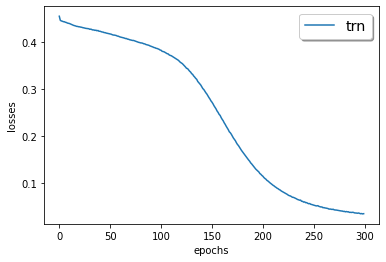

In [7]:
fig, ax = plt.subplots()
plt.xlabel('epochs')
plt.ylabel('losses')
ax.plot(losses, label='trn')
legend = ax.legend(shadow=True, fontsize='x-large')
plt.show()

In [ ]:
def rle(output):
    pixels = output.flatten().astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [ ]:
model = UNet(in_channel,first_out_channel).cuda()
model_name = 'weights.pth'
model.load_state_dict(torch.load(model_name))

In [33]:
######## read images ##############
main_folder = 'vesuvius-challenge-ink-detection/test/'
df = 'b'
    
image_name =main_folder+df+'/surface_volume/00.tif'
image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
(h,w) = image.shape
image = np.expand_dims(image, axis=0)

for i in range(1,65):
    n=str(i)
    if i < 10:
        n=n.zfill(2)

    image_name =main_folder+df+'/surface_volume/'+n+'.tif'
    image = np.concatenate((image,np.expand_dims(cv2.imread(image_name,cv2.IMREAD_GRAYSCALE), axis=0)))

######## end read images ##############

model.eval()
#rle_output = []
with torch.no_grad():
        
    data = getData(typ='test',test_data_folder=[df])
    
    predWhole = np.zeros((h,w), dtype=np.uint8)

    for pixs in data:
        inpt = image[:,pixs[0]:pixs[1],pixs[2]:pixs[3]]
        inpt = np.expand_dims(inpt,0)
        output = model(torch.FloatTensor(inpt).cuda())
        pre_prediction = output.detach().cpu().numpy()[0,0,:,:]
        prediction = np.uint8(np.where(pre_prediction >= 0.5,1,0))
        predWhole[pixs[0]:pixs[1],pixs[2]:pixs[3]] = prediction

#    rle_output.append(rle(predWhole))

#print("Id,Predicted\na," + rle_output[0] + "\nb," + rle_output[1], file=open('submission.csv', 'w'))        

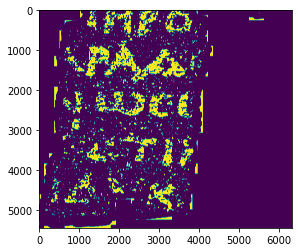

In [34]:
plt.imshow(predWhole)

In [10]:
from skimage import morphology

In [11]:
from scipy.ndimage import label

In [12]:
labeled_array, num_features = label(predWhole)

In [31]:
cleaned = morphology.remove_small_objects(labeled_array, min_size=25000, connectivity=1)

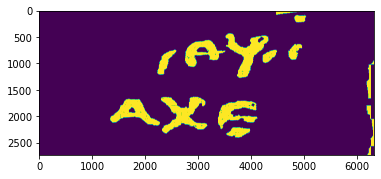

In [32]:
plt.imshow(cleaned>0)

In [ ]:
256*128